In [47]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x

In [49]:
def Diffusion_Coeff(c, D_ref):
  # constants
  #D_ref = 2e-16
  c_max = 4.665e4
  C_theory = 277.84
  C_practical = 160

  # equations
  SOC = (c_max - c)/c_max * C_theory/C_practical
  D = D_ref * (1 + 100*SOC**(3/2))

  return D

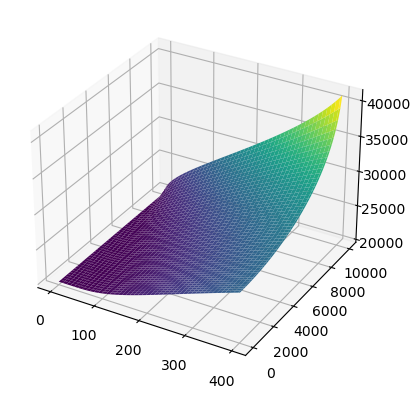

(10001, 401)

In [87]:
numerical = pd.read_csv("MATLAB Solver/data.csv", header=None)
data = numerical.values

# Create a meshgrid for the axes
x = range(data.shape[1])
y = range(data.shape[0])
x, y = np.meshgrid(x, y)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, data, cmap='viridis')

plt.show()
numerical.shape

[[21690 20020 21564 ... 21564 20814 20849]
 [28092 23179 27861 ... 27861 26350 26428]
 [23050 20308 22897 ... 22897 21923 21971]
 ...
 [23430 20443 23270 ... 23270 22246 22298]
 [28209 23259 27975 ... 27975 26452 26531]
 [23138 20337 22984 ... 22984 21997 22047]]


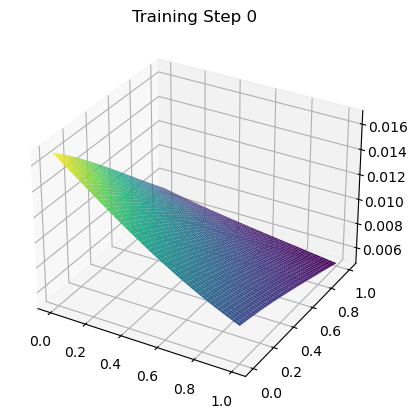

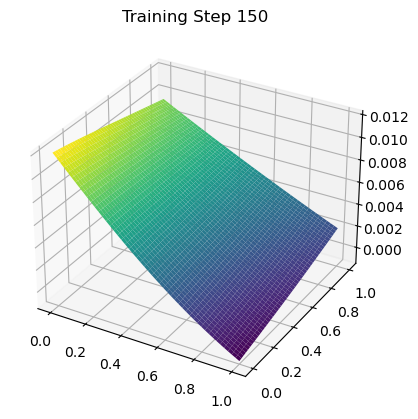

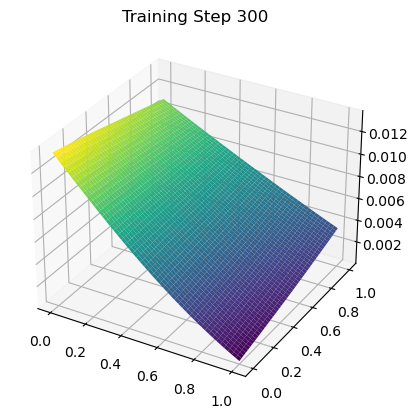

KeyboardInterrupt: 

In [153]:
# define nn to train, two inputs for x and t
pinn = Network(2, 5, 128, 1).to(device)

# parameters and things
Rs = 5e-6
j = -5.35e-5
C0 = 2e4
Cm = 4.665e4

t_points = torch.round(400 * torch.rand(100).view(-1, 1).to(device))
r_points = torch.round(10000 * torch.rand(100).view(-1, 1).to(device))
data = numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)].reset_index(drop=True).values
print(data)


# x and t boundary points for training x boundaries, x = 0,1, varying t values
r0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
rs_boundary = torch.tensor(Rs).view(-1, 1).requires_grad_(True).to(device)
t_boundaries = torch.linspace(0, 400, 100).view(-1, 1).requires_grad_(True).to(device)

# 0 time boundary for training
t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
r_boundary = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)


# training things
epochs = 30000
lr = 1e-5
lambda_r0= 1
lambda_Rs = 1
lambda_t = 1
lambda1 = 1e-4
lambda_phys = 1e-4

def closure():
    # Calculate loss and gradients here
    loss.backward()
    
    return loss

Rs = 5e-6

D_ref = torch.nn.Parameter(torch.zeros(1, requires_grad = True).to(device))

# optimiser
optimiser = torch.optim.Adam(list(pinn.parameters()) + [D_ref], lr = lr)
#optimiser = torch.optim.LBFGS(list(pinn.parameters()) + [D_ref], lr = lr)

losses = []

for e in range(epochs):

  

  optimiser.zero_grad()

  # x, t for phsyics loss
  r_physics = torch.round(10000 * torch.rand(100).requires_grad_(True).to(device))
  t_physics = torch.round(400 * torch.rand(100).requires_grad_(True).to(device))

  # r0 boundary loss
  #outputs = torch.empty(0).to(device)
  #for t in t_boundaries:
  #  t = t.unsqueeze(1)
  #  c = pinn(r0_boundary, t)
  #  c_r = torch.autograd.grad(c, r0_boundary, torch.ones_like(r0_boundary), create_graph = True)[0]
  #  outputs = torch.cat([outputs, c_r], dim = 0)

  #r0_loss = torch.mean(outputs**2)
  #print(f"r0_loss: {r0_loss}")
  
  

  # Rs boundary loss
  #outputs = torch.empty(0).to(device)
  #for t in t_boundaries:
  #  t = t.unsqueeze(1)
  #  c = pinn(rs_boundary, t)
  #  print(c)
  #  c_r = torch.autograd.grad(c, rs_boundary, torch.ones_like(rs_boundary), create_graph = True)[0]
  #  D = Diffusion_Coeff(c)
  #  outputs = torch.cat([outputs, (D*c_r + j)], dim = 0)

  #Rs_loss = torch.mean((outputs)**2)
  #print(f"D: {D.item()}")
  #print(f"Rs_loss: {Rs_loss}")
  

  # t boundary loss
  #outputs = torch.empty(0).to(device)
  #for r in r_boundary:
  #  r = r.unsqueeze(1)
  #  c = pinn(r, t0_boundary)
  #  outputs = torch.cat([outputs, c_r-C0], dim = 0)

  #t_loss = torch.mean(outputs**2)
  #print(f"t_loss: {t_loss}")

  loss1_list = torch.tensor([]).to(device)

  for i in range(len(r_points)):
    r = 1/10000 * r_points[i].view(-1, 1)

    for j in range(len(t_points)):
      t = 1/400 * t_points[j].view(-1, 1)

      loss = torch.mean((pinn(r, t) - data[i, j])**2)
      
      loss1_list = torch.cat([loss1_list, loss.unsqueeze(0)], dim = 0)

  loss1 = torch.mean(loss1_list)

  loss_phys_list = torch.empty(0).to(device)
  # physics loss function
  for i in range(len(r_physics)):
    r = 1/10000 * r_physics[i].view(-1, 1)
    t = 1/400 * t_physics[i].view(-1, 1)

    c = pinn(r, t)
    c_r = torch.autograd.grad(c, r, torch.ones_like(r), create_graph = True)[0]
    c_rr = torch.autograd.grad(c_r, r, torch.ones_like(r), create_graph = True)[0]
    c_t = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    # find and store loss function
    D = Diffusion_Coeff(c, D_ref)
    loss = r**2 * c_t - D*(r/Rs)**2*c_rr - 2*D*r/Rs*c_r
    loss_phys_list = torch.cat([loss_phys_list, loss], dim = 0)


  loss_phys = torch.mean(loss_phys_list**2)
  #print(f"loss_phys: {loss_phys}")

  loss = lambda1 * loss1 +  lambda_phys * loss_phys
  losses.append(loss.cpu().item())
  loss.backward()
  optimiser.step()

  print(f'Iteration: {e}, Loss: {losses[-1]}', end='\r')

  if e % 150 == 0:

    X = torch.linspace(0, 1, 50).to(device)
    T = torch.linspace(0, 1, 50).to(device)
    cs = np.zeros((50, 50))

    for i in range(len(X)):
        x = X[i].view(-1, 1)
        for j in range(len(T)):
            t = T[j].view(-1, 1)

            c = pinn(x, t)
            cs[i, j] = c.item()


    X, T = np.meshgrid(X.cpu().numpy(), T.cpu().numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, cs, cmap='viridis')

    plt.title(f"Training Step {e}")
    plt.show()

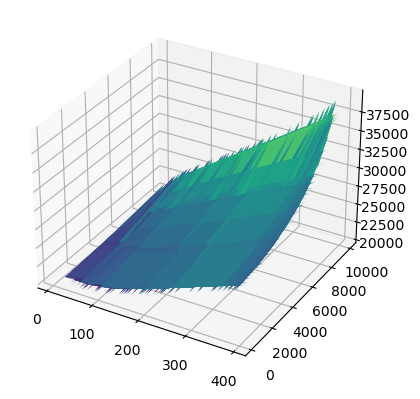

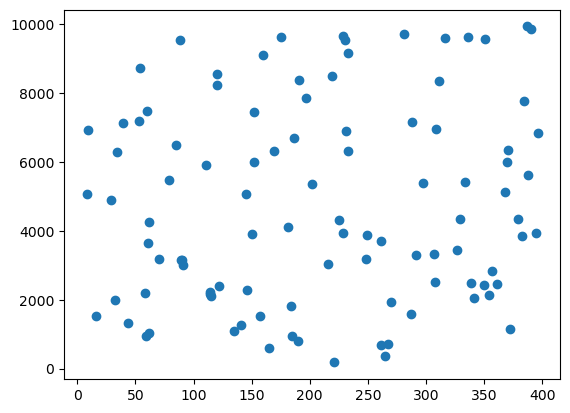

In [123]:
numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)]


r, t = np.meshgrid(t_points.numpy(), r_points.numpy())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r, t, numerical.iloc[r_points.numpy().flatten().astype(int), t_points.numpy().flatten().astype(int)], cmap='viridis')
plt.show()

plt.scatter(t_points, r_points)



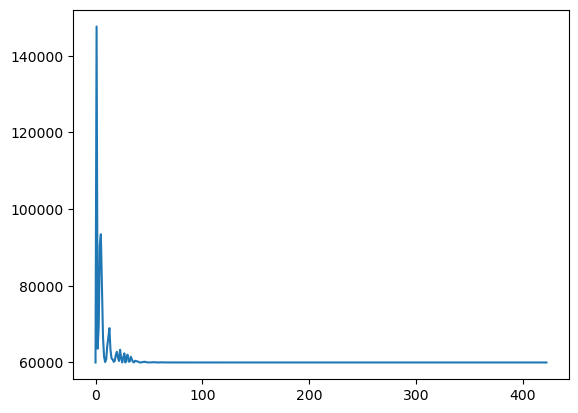

In [154]:
plt.plot(losses)